## 합성곱 신경망(CNN:Convolutional Neural Network)   
***    
CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용된다. 특히 이미지 인식 분야에서 딥러닝을 활용한 기법은 거의 다 CNN을 기초로 한다.   

### 전체구조   
합성곱 계층(convolutional layer)   
풀링 계층(pooling layer)   

완전연결 신경망은 <b>Affine - ReLU</b> 조합으로 이루어져 있고 마지막 계층은 <b>Affine - Softmax</b> 조합이다.   
CNN에서는 <b>Conv-ReLU-(Pooling)</b> 흐름으로 연계된다. 하지만 출력에 가까운 층에서는 <b>Affine-ReLU</b> 구성을 사용할 수 있고 마지막 계층에서는 <b>Affien-Softmax</b> 조합도 사용할 수 있다.   

### 합성곱 계층   
#### 7.2.1 완전연결 계층의 문제점   
완전연결 계층의 문제점은 기존 데이터의 형상이 무시된다는 것이다. 이미지 데이터의 경우 세로, 가로, 색상으로 구성된 3차원 데이터이지만 완전연결 계층에 입력할 때에는 1차원 데이터로 normalize 된다.   
이것은 데이터 형상에 따른 패턴을 무시하는 것이다. 하지만 합성곱 계층은 이 형상을 유지하여 진행한다는 특징이 있다. 그래서 이때의 입출력 데이터를 <b>특징 맵(feature map)</b>이라고 한다.   
#### 7.2.2 합성곱 연산   
입력 데이터에 필터를 합성곱한다.
![convoultional](./images/convolutional.png)   

이때 필터는 완전연결 계층의 가중치 역할을 한다.   

#### 7.2.3 패딩   
합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정 값으로 채우는 것을 의미한다.
> 패딩은 주로 출력 크기를 조정할 목적으로 사용한다. 합성곱 계층을 지나면 크기가 점점 줄어들게 되는데 어느 순간 더 이상 작아질 수 없게 될 수 있기 때문에 임의로 크기 조절을 해줄 수 있다.   
#### 7.2.4 스트라이드   
스트라이드는 필터를 적용하는 위치의 간격을 의미한다. 스트라이드가 2이면 필터를 적용할 때 2칸씩 움직이면서 합성곱 연산을 수행한다.   
#### 7.2.5 3차원 데이터의 합성곱 연산   
3차원 합성곱 연산에서는 입력 데이터의 채널 수와 필터의 채널 수가 같아야 한다.   
#### 7.2.7 배치 처리   
CNN에서의 배치 처리는 입력 데이터의 차원을 하나 더 늘려 4차원으로 만든다. 

### 7.3 풀링 계층   
풀링은 세로, 가로 방향의 공간을 줄이는 연산이다.   
<풀링계층의 특징>
*학습해야 할 매개변수가 없다.   
*채널 수(차원)가 변하지 않는다.   
*입력의 변화에 영향을 적게 받는다(강건하다)   

### im2col   
입력 데이터를 필터링하기 좋게 전개하는 함수이다. 원 데이터에서 필터 적용 영역을 한 줄로 늘어 놓아 2차원 배열로 만들 수 있다.

In [1]:
import sys, os
import numpy as np
sys.path.append(os.pardir)
from common.util import im2col, col2im

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(9, 75)


In [2]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H+2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        #reshape에서 -1를 사용하면 알아서 적절하게 크기를 만들어 준다.
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b

        #인덱스 번호로 transpose하기
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        #dout(N, C, H, W) -> dout(N, H, W, C)
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        #col == im2col 2 dimension matrix (n, data)
        self.dW = np.dot(self.col.T, dout)
        #
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        #col_W = W(필터)를 한줄로 핀 것
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx



In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W-self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        out = np.max(col ,axis=1)
        out = out.reshape(N, out_h,out_w, C).transpose(0, 3, 1, 2)

        return out

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


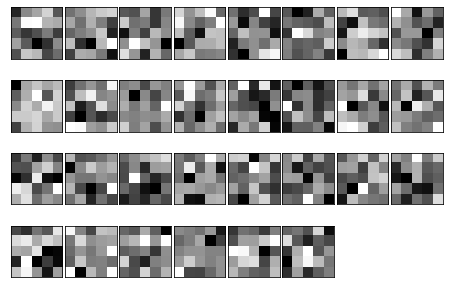

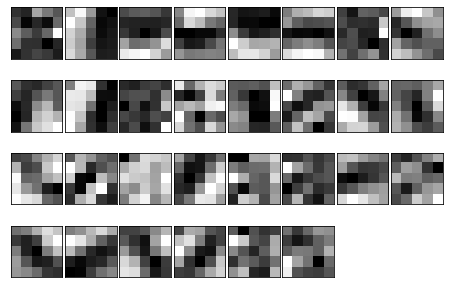

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])
